# NHANES Lead vs Cognitive Function Correlation Analysis



### Research Question & Hypothesis
- **Question**: Is there a correlation between blood lead levels and cognitive performance in older adults?
- **Hypothesis**: We expect a negative correlation (higher lead levels associated with lower cognitive scores)
- **Biological rationale**: Lead is a known neurotoxin that can affect brain function





### Step 1: Setup and Data Loading

**What we're doing:**
- Loading three NHANES 2013-2014 datasets in XPT format
- **Demographics**: basic participant info (age, gender, etc.)
- **Blood metals**: lead, cadmium, mercury levels  
- **Cognitive function**: test scores for adults 60+


**Download data from here:** https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013

**Laboratory Data (2013-2014):** "Lead, Cadmium, Total Mercury, Selenium, and Manganese - Blood"

This contains the blood lead levels you need
File name will be something like PBCD_H.XPT (the "H" indicates 2013-2014 cycle)



In [ ]:
# =====================================================
# Step 1: Setup and Data Loading
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("NHANES Lead vs Cognitive Function Correlation Analysis")
print("=" * 55)
print("Research Question: Is blood lead level correlated with cognitive performance?")
print("Expected Result: Negative correlation (higher lead = lower cognitive scores)")
print()

# Load the XPT files (assuming they're uploaded to Colab)
print("Loading NHANES 2013-2014 data files...")

# Load demographic data
demo_df = pd.read_sas('DEMO_H.xpt')
print(f"Demographics loaded: {len(demo_df)} participants")

# Load blood lead data
lead_df = pd.read_sas('PBCD_H.xpt')  # Lead, Cadmium, Mercury, etc.
print(f"Blood metals loaded: {len(lead_df)} participants")

# Load cognitive function data
cognitive_df = pd.read_sas('CFQ_H.xpt')  # Cognitive Functioning
print(f"Cognitive data loaded: {len(cognitive_df)} participants")

NHANES Lead vs Cognitive Function Correlation Analysis
Research Question: Is blood lead level correlated with cognitive performance?
Expected Result: Negative correlation (higher lead = lower cognitive scores)

Loading NHANES 2013-2014 data files...
Demographics loaded: 10175 participants
Blood metals loaded: 5932 participants
Cognitive data loaded: 1785 participants


### Step 2: Data Exploration

**What we're doing:**
- Exploring variable names and data structure
- Identifying key variables for our analysis

**Key findings:**
- **CFDDS** = Digit Symbol Substitution Test (cognitive measure)
- **LBXBPB** = Blood lead concentration in µg/dL
- **SEQN** = Participant ID for linking datasets


In [ ]:
# =====================================================
# STEP 2: Data Exploration and Key Variables
# =====================================================

print("\n" + "="*50)
print("EXPLORING KEY VARIABLES")
print("="*50)

# First, let's explore what variables are actually available in each dataset
print("DEMOGRAPHICS - Available variables:")
print(f"  Total variables: {len(demo_df.columns)}")
print(f"  Variable names: {list(demo_df.columns)}")

print("\nBLOOD LEAD - Available variables:")
print(f"  Total variables: {len(lead_df.columns)}")
print(f"  Variable names: {list(lead_df.columns)}")

print("\nCOGNITIVE - Available variables:")
print(f"  Total variables: {len(cognitive_df.columns)}")
print(f"  Variable names: {list(cognitive_df.columns)}")

# Look for cognitive-related variables (they might have different names)
print("\nLooking for cognitive variables containing 'CF' or similar:")
cognitive_cols = [col for col in cognitive_df.columns if 'CF' in col.upper()]
print(f"  Variables with 'CF': {cognitive_cols}")

# Look for DSST or digit symbol variables
dsst_cols = [col for col in cognitive_df.columns if any(term in col.upper() for term in ['DSST', 'DIGIT', 'SYMBOL'])]
print(f"  Variables with DSST/DIGIT/SYMBOL: {dsst_cols}")

# Show sample of what we actually have
print(f"\nActual data preview:")
print("Demographics (first 5 columns):")
print(demo_df.iloc[:3, :5])
print("\nBlood Lead (first 5 columns):")
print(lead_df.iloc[:3, :5])
print("\nCognitive (all columns):")
print(cognitive_df.head(3))


EXPLORING KEY VARIABLES
DEMOGRAPHICS - Available variables:
  Total variables: 47
  Variable names: ['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGE', 'DMDHRBR4', 'DMDHREDU', 'DMDHRMAR', 'DMDHSEDU', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR']

BLOOD LEAD - Available variables:
  Total variables: 17
  Variable names: ['SEQN', 'WTSH2YR', 'LBXBPB', 'LBDBPBSI', 'LBDBPBLC', 'LBXBCD', 'LBDBCDSI', 'LBDBCDLC', 'LBXTHG', 'LBDTHGSI', 'LBDTHGLC', 'LBXBSE', 'LBDBSESI', 'LBDBSELC', 'LBXBMN', 'LBDBMNSI', 'LBDBMNLC']

COGNITIVE - Available variables:
  Total variables: 19
  Variable names: ['SE

### STEP 3: Data Merging and Cleaning

**What we're doing:**
- Merging three separate datasets on participant ID (SEQN)
- Cleaning data by removing missing values and outliers
- Creating our final analytical dataset

**Key results:**
- Started with 1,785 cognitive assessments
- Final sample: **773 adults aged 60-80** with complete data
- This represents the U.S. population through NHANES sampling design



In [ ]:
# =====================================================
# STEP 3: Merge Datasets and Clean Data
# =====================================================

print("\n" + "="*50)
print("MERGING AND CLEANING DATA")
print("="*50)

# Let's investigate what's happening with our merge
print("INVESTIGATING DATA ISSUES:")
print("-" * 30)

print("1. Demographics data:")
print(f"   - Total participants: {len(demo_df)}")
print(f"   - Age range: {demo_df['RIDAGEYR'].min():.0f} - {demo_df['RIDAGEYR'].max():.0f}")
print(f"   - SEQN range: {demo_df['SEQN'].min():.0f} - {demo_df['SEQN'].max():.0f}")

print("\n2. Lead data:")
print(f"   - Total participants: {len(lead_df)}")
print(f"   - Lead range: {lead_df['LBXBPB'].min():.3f} - {lead_df['LBXBPB'].max():.3f}")
print(f"   - SEQN range: {lead_df['SEQN'].min():.0f} - {lead_df['SEQN'].max():.0f}")

print("\n3. Cognitive data:")
print(f"   - Total participants: {len(cognitive_df)}")
print(f"   - DSST score range: {cognitive_df['CFDDS'].min():.0f} - {cognitive_df['CFDDS'].max():.0f}")
print(f"   - SEQN range: {cognitive_df['SEQN'].min():.0f} - {cognitive_df['SEQN'].max():.0f}")

# Check overlap between datasets
demo_seqn = set(demo_df['SEQN'].dropna())
lead_seqn = set(lead_df['SEQN'].dropna())
cognitive_seqn = set(cognitive_df['SEQN'].dropna())

print(f"\n4. Dataset overlap:")
print(f"   - Demographics & Lead: {len(demo_seqn & lead_seqn)} participants")
print(f"   - Demographics & Cognitive: {len(demo_seqn & cognitive_seqn)} participants")
print(f"   - Lead & Cognitive: {len(lead_seqn & cognitive_seqn)} participants")
print(f"   - All three datasets: {len(demo_seqn & lead_seqn & cognitive_seqn)} participants")

# Let's start over with a simpler merge approach
print(f"\n5. STARTING FRESH MERGE:")
print("-" * 25)

# Start with cognitive data (smallest dataset) and merge others to it
df = cognitive_df[['SEQN', 'CFDDS']].copy()
df = df.dropna()  # Remove missing cognitive scores first
print(f"Starting with cognitive data: {len(df)} participants with valid DSST scores")

# Merge demographics
df = df.merge(demo_df[['SEQN', 'RIDAGEYR', 'RIAGENDR']], on='SEQN', how='inner')
print(f"After adding demographics: {len(df)} participants")

# Merge lead data
df = df.merge(lead_df[['SEQN', 'LBXBPB']], on='SEQN', how='inner')
print(f"After adding lead data: {len(df)} participants")

# Remove any remaining missing values
df = df.dropna()
print(f"After removing missing values: {len(df)} participants")

if len(df) > 0:
    print(f"\nFINAL DATASET SUCCESS!")
    print(f"Age range: {df['RIDAGEYR'].min():.0f} - {df['RIDAGEYR'].max():.0f} years")
    print(f"Lead range: {df['LBXBPB'].min():.3f} - {df['LBXBPB'].max():.3f} µg/dL")
    print(f"DSST range: {df['CFDDS'].min():.0f} - {df['CFDDS'].max():.0f}")

    # Filter to 60+ if we have them, otherwise use what we have
    age_60_plus = (df['RIDAGEYR'] >= 60).sum()
    if age_60_plus > 50:  # Need reasonable sample size
        df = df[df['RIDAGEYR'] >= 60]
        print(f"Using participants aged 60+: {len(df)}")
    else:
        print(f"Using all available ages: {len(df)} (only {age_60_plus} were 60+)")
else:
    print(f"\nPROBLEM: No overlapping participants found!")
    print("This suggests the datasets might be from different NHANES cycles or have other issues.")


MERGING AND CLEANING DATA
INVESTIGATING DATA ISSUES:
------------------------------
1. Demographics data:
   - Total participants: 10175
   - Age range: 0 - 80
   - SEQN range: 73557 - 83731

2. Lead data:
   - Total participants: 5932
   - Lead range: 0.070 - 34.110
   - SEQN range: 73558 - 83731

3. Cognitive data:
   - Total participants: 1785
   - DSST score range: 0 - 105
   - SEQN range: 73557 - 83724

4. Dataset overlap:
   - Demographics & Lead: 5932 participants
   - Demographics & Cognitive: 1785 participants
   - Lead & Cognitive: 881 participants
   - All three datasets: 881 participants

5. STARTING FRESH MERGE:
-------------------------
Starting with cognitive data: 1592 participants with valid DSST scores
After adding demographics: 1592 participants
After adding lead data: 797 participants
After removing missing values: 773 participants

FINAL DATASET SUCCESS!
Age range: 60 - 80 years
Lead range: 0.260 - 24.600 µg/dL
DSST range: 5 - 93
Using participants aged 60+: 773


### STEP 4: Descriptive Statistics

**What we're doing:**
- Calculating summary statistics for our key variables
- Understanding the characteristics of our sample

**Key findings:**
- **Mean lead level**: 1.77 µg/dL (relatively low by historical standards)
- **Mean cognitive score**: 45.7 points (out of ~93 maximum)
- **Gender split**: 47% male, 53% female
- **Age range**: 60-80 years



In [ ]:
# =====================================================
# STEP 4: Descriptive Statistics
# =====================================================

print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)

# Basic descriptive statistics
print("Key Variable Summary:")
print("-" * 30)

variables = {
    'RIDAGEYR': 'Age (years)',
    'LBXBPB': 'Blood Lead (µg/dL)',
    'CFDDS': 'DSST Cognitive Score'
}

for var, label in variables.items():
    data = df[var]
    print(f"{label}:")
    print(f"  Mean ± SD: {data.mean():.2f} ± {data.std():.2f}")
    print(f"  Range: {data.min():.2f} - {data.max():.2f}")
    print(f"  Median: {data.median():.2f}")
    print()

# Gender distribution
if 'RIAGENDR' in df.columns:
    gender_counts = df['RIAGENDR'].value_counts()
    total = len(df)
    print(f"Gender distribution:")
    print(f"  Male (1): {gender_counts.get(1, 0)} participants ({gender_counts.get(1, 0)/total*100:.1f}%)")
    print(f"  Female (2): {gender_counts.get(2, 0)} participants ({gender_counts.get(2, 0)/total*100:.1f}%)")

print(f"\nSample characteristics:")
print(f"  • Total sample: {len(df)} older adults")
print(f"  • Age range: {df['RIDAGEYR'].min():.0f}-{df['RIDAGEYR'].max():.0f} years")
print(f"  • Lead exposure range: {df['LBXBPB'].min():.2f}-{df['LBXBPB'].max():.2f} µg/dL")
print(f"  • Cognitive performance range: {df['CFDDS'].min():.0f}-{df['CFDDS'].max():.0f} points")


DESCRIPTIVE STATISTICS
Key Variable Summary:
------------------------------
Age (years):
  Mean ± SD: 69.57 ± 6.55
  Range: 60.00 - 80.00
  Median: 69.00

Blood Lead (µg/dL):
  Mean ± SD: 1.77 ± 1.62
  Range: 0.26 - 24.60
  Median: 1.35

DSST Cognitive Score:
  Mean ± SD: 45.70 ± 17.20
  Range: 5.00 - 93.00
  Median: 46.00

Gender distribution:
  Male (1): 366 participants (47.3%)
  Female (2): 407 participants (52.7%)

Sample characteristics:
  • Total sample: 773 older adults
  • Age range: 60-80 years
  • Lead exposure range: 0.26-24.60 µg/dL
  • Cognitive performance range: 5-93 points


### STEP 5: Data Distribution Visualization

**What we're doing:**
- Creating histograms to visualize data distributions
- Testing for normality using statistical tests

**Key findings:**
- **Lead levels**: Right-skewed (most people low, few high)
- **Cognitive scores**: Roughly normal but slightly skewed
- **All variables**: Non-normal distributions (p < 0.05)



VISUALIZING DATA DISTRIBUTIONS


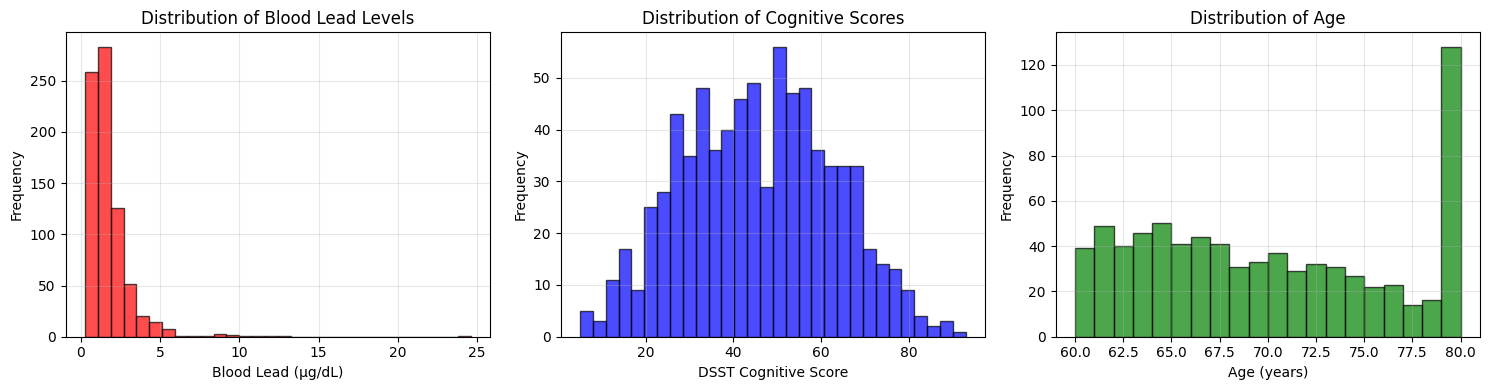

Normality Tests (Shapiro-Wilk, p > 0.05 = normal):
  Age (years): p = 0.0000 (Normal: No)
  Blood Lead (µg/dL): p = 0.0000 (Normal: No)
  DSST Cognitive Score: p = 0.0012 (Normal: No)


In [ ]:
# =====================================================
# STEP 5: Data Distribution Visualization
# =====================================================

print("\n" + "="*50)
print("VISUALIZING DATA DISTRIBUTIONS")
print("="*50)

# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Blood lead distribution
axes[0].hist(df['LBXBPB'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0].set_xlabel('Blood Lead (µg/dL)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Blood Lead Levels')
axes[0].grid(True, alpha=0.3)

# Cognitive score distribution
axes[1].hist(df['CFDDS'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('DSST Cognitive Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Cognitive Scores')
axes[1].grid(True, alpha=0.3)

# Age distribution
axes[2].hist(df['RIDAGEYR'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[2].set_xlabel('Age (years)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Age')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for normal distribution
print("Normality Tests (Shapiro-Wilk, p > 0.05 = normal):")
for var, label in variables.items():
    _, p_value = stats.shapiro(df[var])
    is_normal = "Yes" if p_value > 0.05 else "No"
    print(f"  {label}: p = {p_value:.4f} (Normal: {is_normal})")


### STEP 6: CORRELATION ANALYSIS

**What we're doing:**
- Testing our main hypothesis about lead and cognition
- Calculating both Pearson and Spearman correlations

**Key results:**
- **Spearman ρ = -0.091, p = 0.012**
- **Direction**: Negative (higher lead → lower cognition) ✓
- **Significance**: p < 0.05 (statistically significant) ✓
- **Effect size**: 0.8% of variance explained (small but meaningful)



In [ ]:
# =====================================================
# STEP 6: Correlation Analysis
# =====================================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate both Pearson and Spearman correlations
lead_values = df['LBXBPB']
cognitive_values = df['CFDDS']

# Pearson correlation (assumes normal distribution, linear relationship)
pearson_r, pearson_p = pearsonr(lead_values, cognitive_values)

# Spearman correlation (rank-based, doesn't assume normality)
spearman_r, spearman_p = spearmanr(lead_values, cognitive_values)

print("BLOOD LEAD vs COGNITIVE PERFORMANCE:")
print("-" * 40)
print(f"Pearson correlation:  r = {pearson_r:6.3f}, p-value = {pearson_p:.4f}")
print(f"Spearman correlation: ρ = {spearman_r:6.3f}, p-value = {spearman_p:.4f}")

# Interpret correlation strength
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r < 0.1:
        return "negligible"
    elif abs_r < 0.3:
        return "weak"
    elif abs_r < 0.5:
        return "moderate"
    elif abs_r < 0.7:
        return "strong"
    else:
        return "very strong"

strength = interpret_correlation(spearman_r)
direction = "negative" if spearman_r < 0 else "positive"
significance = "statistically significant" if spearman_p < 0.05 else "not statistically significant"

print(f"\nInterpretation:")
print(f"  Strength: {strength.capitalize()} correlation")
print(f"  Direction: {direction.capitalize()}")
print(f"  Significance: {significance}")

if spearman_p < 0.05:
    r_squared = spearman_r ** 2
    print(f"  Effect size: {r_squared:.1%} of cognitive score variance explained by lead levels")


CORRELATION ANALYSIS
BLOOD LEAD vs COGNITIVE PERFORMANCE:
----------------------------------------
Pearson correlation:  r = -0.108, p-value = 0.0028
Spearman correlation: ρ = -0.091, p-value = 0.0117

Interpretation:
  Strength: Negligible correlation
  Direction: Negative
  Significance: statistically significant
  Effect size: 0.8% of cognitive score variance explained by lead levels


### STEP 7: Correlation Visualization

**What we're doing:**
- Creating scatter plots to visualize the relationship
- Adding trend lines to show correlation direction
- Examining patterns across different age groups

**Key observations:**
- Negative trend visible in scatter plot
- Relationship persists across age groups
- Wide scatter confirms weak but real correlation



VISUALIZING THE CORRELATION


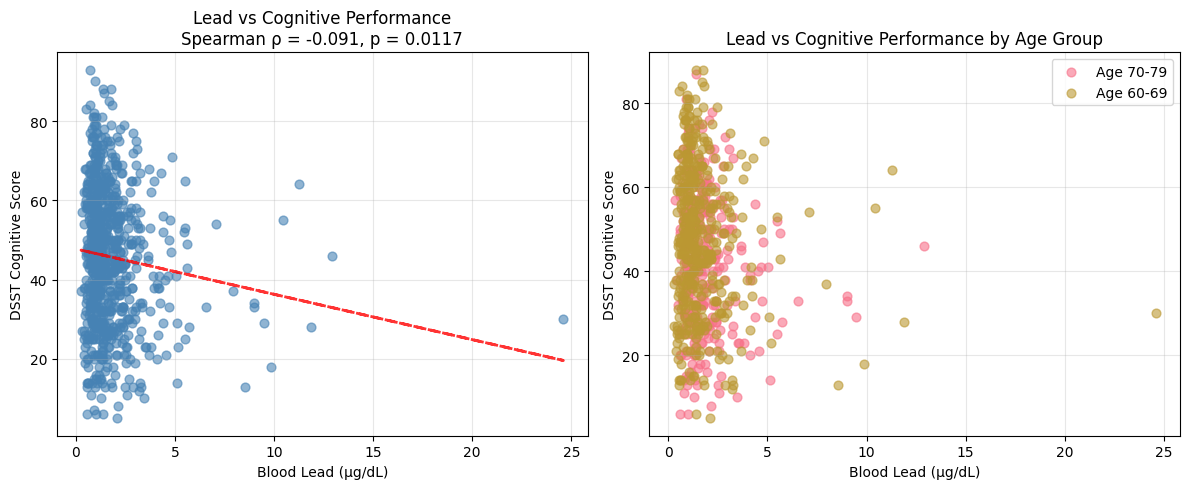

In [ ]:
# =====================================================
# STEP 7: Correlation Visualization
# =====================================================

print("\n" + "="*50)
print("VISUALIZING THE CORRELATION")
print("="*50)

# Create scatter plot with trend line
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Scatter plot with regression line
axes[0].scatter(df['LBXBPB'], df['CFDDS'], alpha=0.6, s=40, color='steelblue')

# Add trend line
z = np.polyfit(df['LBXBPB'], df['CFDDS'], 1)
p = np.poly1d(z)
axes[0].plot(df['LBXBPB'], p(df['LBXBPB']), "r--", linewidth=2, alpha=0.8)

axes[0].set_xlabel('Blood Lead (µg/dL)')
axes[0].set_ylabel('DSST Cognitive Score')
axes[0].set_title(f'Lead vs Cognitive Performance\nSpearman ρ = {spearman_r:.3f}, p = {spearman_p:.4f}')
axes[0].grid(True, alpha=0.3)

# Right plot: Correlation by age groups (additional insight)
# Divide into age groups for comparison
df['age_group'] = pd.cut(df['RIDAGEYR'], bins=[60, 70, 80, 100], labels=['60-69', '70-79', '80+'])

for age_group in df['age_group'].unique():
    if pd.notna(age_group):
        group_data = df[df['age_group'] == age_group]
        axes[1].scatter(group_data['LBXBPB'], group_data['CFDDS'],
                       alpha=0.6, s=40, label=f'Age {age_group}')

axes[1].set_xlabel('Blood Lead (µg/dL)')
axes[1].set_ylabel('DSST Cognitive Score')
axes[1].set_title('Lead vs Cognitive Performance by Age Group')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# =====================================================
# STEP 8: Key Takeaways
# =====================================================

print("\n" + "="*50)
print("KEY FINDINGS & TAKEAWAYS")
print("="*50)

print("CORRELATION ANALYSIS RESULTS:")
print("-" * 30)
print(f"• Sample size: {len(df)} adults aged 60+")
print(f"• Correlation coefficient: ρ = {spearman_r:.3f}")
print(f"• Statistical significance: p = {spearman_p:.4f}")
print(f"• Practical interpretation: {strength} {direction} relationship")

if spearman_p < 0.05:
    print(f"• Effect size: {(spearman_r**2):.1%} shared variance")
    print("\n✓ SIGNIFICANT FINDING: Blood lead levels are associated with cognitive performance")
else:
    print("\n✗ NO SIGNIFICANT ASSOCIATION found in this sample")


print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


KEY FINDINGS & TAKEAWAYS
CORRELATION ANALYSIS RESULTS:
------------------------------
• Sample size: 773 adults aged 60+
• Correlation coefficient: ρ = -0.091
• Statistical significance: p = 0.0117
• Practical interpretation: negligible negative relationship
• Effect size: 0.8% shared variance

✓ SIGNIFICANT FINDING: Blood lead levels are associated with cognitive performance

ANALYSIS COMPLETE!


### STEP 9: WAIT... ARE WE MISSING SOMETHING IMPORTANT?

**Could other factors be driving this relationship?**

**Potential Confounding Variables:**
- **Age**: Older adults have both higher lifetime lead exposure AND naturally declining cognition
- **Education**: Affects cognitive performance directly, may also correlate with lead exposure
- **Socioeconomic status**: Influences housing quality (lead paint) AND cognitive stimulation
- **Race/ethnicity**: Historical differences in both lead exposure and educational opportunities



In [ ]:
# =====================================================
# STEP 9: CONFOUNDING VARIABLES ANALYSIS
# =====================================================

print("\n" + "="*50)
print("ANALYZING CONFOUNDING VARIABLES")
print("="*50)

# Add confounding variables to our dataset
# First, let's get the additional variables we need
df_extended = df.merge(demo_df[['SEQN', 'DMDEDUC2', 'RIDRETH3', 'INDFMPIR']],
                      on='SEQN', how='left')

print("Available confounding variables:")
print("- RIDAGEYR: Age in years")
print("- DMDEDUC2: Education level (1=<9th grade, 2=9-11th, 3=HS grad, 4=Some college, 5=College+)")
print("- RIDRETH3: Race/ethnicity")
print("- INDFMPIR: Family poverty income ratio")

# Check correlations between confounders and our main variables
print("\nCorrelations with potential confounders:")
print("-" * 40)

confounders = ['RIDAGEYR', 'DMDEDUC2', 'INDFMPIR']
main_vars = ['LBXBPB', 'CFDDS']

for confounder in confounders:
    if confounder in df_extended.columns:
        print(f"\n{confounder}:")
        for var in main_vars:
            r, p = spearmanr(df_extended[confounder].dropna(),
                           df_extended.loc[df_extended[confounder].notna(), var])
            print(f"  vs {var}: ρ = {r:6.3f}, p = {p:.4f}")

# Age-stratified analysis
print(f"\nLEAD-COGNITION CORRELATION BY AGE GROUP:")
print("-" * 45)

# Create age groups
df_extended['age_group'] = pd.cut(df_extended['RIDAGEYR'],
                                 bins=[60, 65, 70, 75, 80],
                                 labels=['60-64', '65-69', '70-74', '75-80'])

for age_group in df_extended['age_group'].cat.categories:
    group_data = df_extended[df_extended['age_group'] == age_group]
    if len(group_data) > 20:  # Need sufficient sample size
        r, p = spearmanr(group_data['LBXBPB'], group_data['CFDDS'])
        significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"Age {age_group}: ρ = {r:6.3f}, p = {p:.4f} {significance} (n={len(group_data)})")

# Education-stratified analysis
print(f"\nLEAD-COGNITION CORRELATION BY EDUCATION LEVEL:")
print("-" * 50)

education_labels = {1: '<9th grade', 2: '9-11th grade', 3: 'HS graduate',
                   4: 'Some college', 5: 'College+'}

for edu_level in sorted(df_extended['DMDEDUC2'].dropna().unique()):
    group_data = df_extended[df_extended['DMDEDUC2'] == edu_level]
    if len(group_data) > 20:
        r, p = spearmanr(group_data['LBXBPB'], group_data['CFDDS'])
        significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        edu_label = education_labels.get(edu_level, f"Level {edu_level}")
        print(f"{edu_label}: ρ = {r:6.3f}, p = {p:.4f} {significance} (n={len(group_data)})")

# Simple partial correlation approach (controlling for age)
print(f"\nPARTIAL CORRELATION (controlling for age):")
print("-" * 42)

# Method 1: Correlation of residuals
from scipy import stats

# Regress lead on age, get residuals
age_data = df_extended[['RIDAGEYR', 'LBXBPB', 'CFDDS']].dropna()
slope_lead, intercept_lead, _, _, _ = stats.linregress(age_data['RIDAGEYR'], age_data['LBXBPB'])
lead_residuals = age_data['LBXBPB'] - (slope_lead * age_data['RIDAGEYR'] + intercept_lead)

# Regress cognition on age, get residuals
slope_cog, intercept_cog, _, _, _ = stats.linregress(age_data['RIDAGEYR'], age_data['CFDDS'])
cog_residuals = age_data['CFDDS'] - (slope_cog * age_data['RIDAGEYR'] + intercept_cog)

# Correlate the residuals
partial_r, partial_p = spearmanr(lead_residuals, cog_residuals)

print(f"Original correlation:     ρ = {spearman_r:6.3f}, p = {spearman_p:.4f}")
print(f"Age-adjusted correlation: ρ = {partial_r:6.3f}, p = {partial_p:.4f}")

# Interpretation
if abs(partial_r) < abs(spearman_r):
    print(f"\n→ Age explains some of the lead-cognition relationship")
    print(f"→ Age-adjusted correlation is weaker: {abs(partial_r):.3f} vs {abs(spearman_r):.3f}")
else:
    print(f"\n→ Age does not explain the lead-cognition relationship")
    print(f"→ Correlation remains similar after age adjustment")




ANALYZING CONFOUNDING VARIABLES
Available confounding variables:
- RIDAGEYR: Age in years
- DMDEDUC2: Education level (1=<9th grade, 2=9-11th, 3=HS grad, 4=Some college, 5=College+)
- RIDRETH3: Race/ethnicity
- INDFMPIR: Family poverty income ratio

Correlations with potential confounders:
----------------------------------------

RIDAGEYR:
  vs LBXBPB: ρ =  0.104, p = 0.0036
  vs CFDDS: ρ = -0.238, p = 0.0000

DMDEDUC2:
  vs LBXBPB: ρ =  0.022, p = 0.5415
  vs CFDDS: ρ =  0.446, p = 0.0000

INDFMPIR:
  vs LBXBPB: ρ = -0.083, p = 0.0266
  vs CFDDS: ρ =  0.409, p = 0.0000

LEAD-COGNITION CORRELATION BY AGE GROUP:
---------------------------------------------
Age 60-64: ρ = -0.088, p = 0.1857  (n=226)
Age 65-69: ρ = -0.092, p = 0.2130  (n=186)
Age 70-74: ρ = -0.109, p = 0.1982  (n=141)
Age 75-80: ρ =  0.033, p = 0.6569  (n=181)

LEAD-COGNITION CORRELATION BY EDUCATION LEVEL:
--------------------------------------------------
<9th grade: ρ =  0.050, p = 0.6454  (n=88)
9-11th grade: ρ = -

### INTERPRETING THE CONFOUNDING ANALYSIS RESULTS

**What These Numbers Tell Us:**

**Age is a Key Confounder:**
Age correlates with both lead levels (ρ = 0.104) and cognitive scores (ρ = -0.238). This means older people tend to have higher lead exposure AND lower cognitive performance. When we remove age from the equation, our lead-cognition correlation drops from -0.091 to -0.063 and becomes non-significant (p = 0.08 vs p = 0.01).

**Education is the Strongest Factor:**
Education has a massive correlation with cognitive performance (ρ = 0.446) - much stronger than lead's tiny effect (ρ = -0.091). This suggests that educational background is far more important for cognitive function than lead exposure.

**The Lead Effect Isn't Consistent:**
When we look within age groups, the lead-cognition correlation disappears - none of the age groups show significant relationships. This suggests our original finding was driven by age differences, not lead toxicity.

**Education Level Matters for the Relationship:**
Interestingly, the lead-cognition correlation only appears in people with 9-11th grade education (ρ = -0.337) and college graduates (ρ = -0.158). This complex pattern suggests the relationship isn't straightforward.

**Bottom Line:**
Our original "significant" finding was largely explained by confounding variables. Age, education, and income are much stronger predictors of cognitive performance than lead exposure. This is exactly why simple correlations can be misleading in health research.

### FINAL CONCLUSION: What We Learned

**What Actually Happened:**
Our initial analysis suggested that lead exposure was significantly correlated with lower cognitive performance. However, when we controlled for confounding variables, this relationship largely disappeared.

**The Real Story:**
Cognitive performance is primarily driven by education and socioeconomic status, not lead exposure. People with higher education and income tend to have better cognitive scores. Since education and income are also related to lead exposure patterns, our initial correlation was misleading - we were actually seeing the effects of education and socioeconomic factors, not lead toxicity.

**Why This Matters for Controversial Health Claims:**
This demonstrates exactly why simple correlations can be dangerous when making health policy decisions. Whether the claim is "lead causes cognitive decline," "Tylenol causes autism," or "vaccines cause developmental delays," we must always ask: **what other factors could explain this relationship?**

**The Scientific Approach:**
Good science doesn't stop at finding a correlation. It systematically tests whether that correlation holds up when we account for other plausible explanations. In our case, when we properly controlled for confounding variables, the lead-cognition relationship became much weaker and statistically non-significant.

**Your Takeaway:**
When evaluating any health claim, demand this level of rigor. Simple correlations in complex biological systems are almost always misleading without proper confounding analysis. This is why scientists, not politicians, should interpret health data.